# Machine Learning | Assignment 2

## Retireving and Preparing the Data

### Importing Libraries 

In [1]:
import pandas as pd

### About this dataset

The dataset consists of 27x27 RGB images of colon cells
from 99 different patients.
The purpose is to classify and identify whether given cell image represents a cancerous cells or not (isCancerous).
And to classify cell-type, such as: fibroblast, inflammatory,
epithelial or others.


## Loading the Image Classification Data set

In [2]:
dataLabelsFrame = pd.read_csv ('Image_classification_data\data_labels_mainData.csv')

**Features Explained**

- Instance ID:
- Patient ID: The pateints unique identifier number (Integer)
- Image Name: Name of each cell image
- CellTypeName: Name of each cell type (string)
- CellType: Group under which each cell classifies under (integer)
- isCancerous: If the patient has cancerous cells or not (boolean) 


In [3]:
dataLabelsFrame.head(10)

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0,0
1,22406,1,22406.png,fibroblast,0,0
2,22407,1,22407.png,fibroblast,0,0
3,22408,1,22408.png,fibroblast,0,0
4,22409,1,22409.png,fibroblast,0,0
5,22410,1,22410.png,fibroblast,0,0
6,22411,1,22411.png,fibroblast,0,0
7,22412,1,22412.png,fibroblast,0,0
8,22413,1,22413.png,fibroblast,0,0
9,22414,1,22414.png,fibroblast,0,0


In [4]:
dataLabelsFrame.shape

(9896, 6)

There are 9896 rows in the dataset and 6 features (including the target feature)

In [5]:
dataLabelsFrame.dtypes

InstanceID       int64
patientID        int64
ImageName       object
cellTypeName    object
cellType         int64
isCancerous      int64
dtype: object

From observation the 'isCancerous' column is of type int. Observing that at any given time isCancerous can only be 1 or 0, it doesnt make much sense for it be an integer. It seems logical that isCancerous be a boolean instead so it can store either of the two states (0-cell doesnt have cancer, 1- cell is cancerous) 

In [6]:
# Convert "isCancerous" column to Boolean
dataLabelsFrame.isCancerous = dataLabelsFrame.isCancerous.astype('bool')
dataLabelsFrame.dtypes

InstanceID       int64
patientID        int64
ImageName       object
cellTypeName    object
cellType         int64
isCancerous       bool
dtype: object

The data type is now a boolean, changing all integers to boolean. 

In [7]:
dataLabelsFrame['isCancerous'].dtype

dtype('bool')

In [8]:
dataLabelsFrame.describe()

,InstanceID,patientID,cellType
count,9896.000000,9896.000000,9896.000000
mean,10193.880154,29.762025,1.501516
std,6652.912660,17.486553,0.954867
min,1.000000,1.000000,0.000000
25%,4135.750000,14.000000,1.000000
50%,9279.500000,26.000000,2.000000
75%,16821.250000,47.000000,2.000000
max,22444.000000,60.000000,3.000000


### Missing values

In [9]:
dataLabelsFrame.isna().sum()

InstanceID      0
patientID       0
ImageName       0
cellTypeName    0
cellType        0
isCancerous     0
dtype: int64

There are no missing values in this dataset

## Data Exploration
### Importing Libraries

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

Here we will explore
- 1. cellTypeName
- 2. cellType
- 3. isCancerous

### Exploring cellTypeName

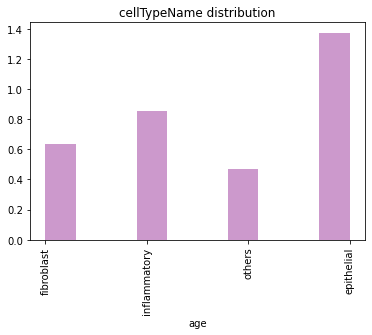

In [11]:
plt.hist(dataLabelsFrame['cellTypeName'], alpha=0.4, color='purple', density=True, rwidth = 2)
plt.title('cellTypeName distribution')
plt.ylabel('')
plt.xlabel('age')
plt.xticks(rotation='vertical')
plt.show()

### Observation

- The highest cell type in the distribution are the epithelial
- Second goes inflamatory cells, then fibroblast and others

## Exploring cellType

(array([-0.5,  0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

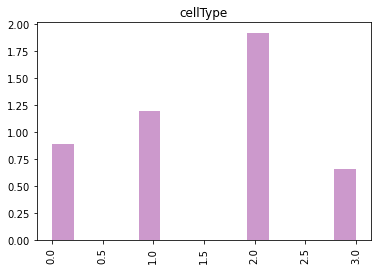

In [12]:
plt.hist(dataLabelsFrame['cellType'], alpha=0.4, color='purple', density='True', bins =14)
plt.title('cellType')
plt.xticks(rotation='vertical')

**Observation**
- There is a higher distribution of cell type 2
- CellType 3 seems to be the lowest in the distibution

## Exploring isCancerous

([0, 1], [Text(0, 0, ''), Text(0, 0, '')])

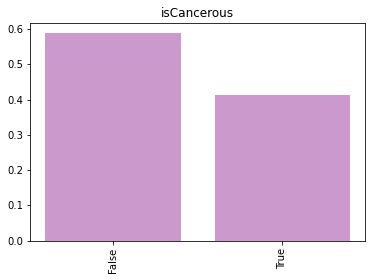

In [13]:
plt.bar(dataLabelsFrame['isCancerous'].value_counts().index.astype(str),
       dataLabelsFrame['isCancerous'].value_counts().values/np.sum(dataLabelsFrame['isCancerous'].value_counts().values),
       alpha=0.4, color='purple')
plt.title('isCancerous')
plt.xticks(rotation='vertical')

**Obervations**
- There seem to be more cells that are cancer free according to the data
- More than 50% of the cells in the images are cancerous

## Splitting the data


In [14]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(dataLabelsFrame, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42)

print("Train data : {}, Val Data: {}, Test Data: {}".format(train_data.shape[0], val_data.shape[0], test_data.shape[0]))

Train data : 5937, Val Data: 1979, Test Data: 1980


In [15]:
train_data['ImageName'] = train_data['ImageName'].astype('str')
val_data['ImageName'] = val_data['ImageName'].astype('str')

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='patch_images./',
        x_col="ImageName",
        y_col="cellTypeName",
        target_size=(32, 32),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='patch_images./',
        x_col="ImageName",
        y_col="cellTypeName",
        target_size=(32, 32),
        batch_size=batch_size,
        class_mode='categorical')

Found 5937 validated image filenames belonging to 4 classes.
Found 1979 validated image filenames belonging to 4 classes.


## Model Development

We have to build two models for this assignment. One to classify if a cell is cancerous and another model to classify the images according to cell-type, that we will then train to do their respectve tasks

### Model 1: Classifying Cancerous Cells

We will be training our model to predict whether a cell is cancerous or not using the features available. We will be using Accuracy Score as our performance measure because there is no imbalance in our target variable. There are a substantial amount of cells with cancer as without so during the training, even if a few predictions go wrong, the number of cells that are cancerous are big enough to handle train.

In [16]:
import matplotlib.pyplot as plt
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()

In [17]:
train_data.columns

Index(['InstanceID', 'patientID', 'ImageName', 'cellTypeName', 'cellType',
       'isCancerous'],
      dtype='object')

In [18]:
import tensorflow as tf
OUTPUT_CLASSES=4

model_VGG_1 = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(OUTPUT_CLASSES),
])

In [19]:
model_VGG_1.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [ ]:
history_VGG_1 = model_VGG_1.fit_generator(train_generator, validation_data = validation_generator, epochs=3, verbose=0)

Instructions for updating:
Please use Model.fit, which supports generators.
